# Predicting heart disease using maching learning

<img src="data/heart_disease.jpg">

**Introduction**

According to the [National Heart, Lung and Blood Institute](https://www.nhlbi.nih.gov/health-topics/coronary-heart-disease):
>Heart disease is a catch-all phrase for a variety of conditions that affect the heart’s structure and function. Coronary heart disease is a type of heart disease that develops when the arteries of the heart cannot deliver enough oxygen-rich blood to the heart. It is the leading cause of death in the United States.

Also, according to the [World Health Organization](https://www.who.int/health-topics/cardiovascular-diseases), cardiovascular diseases are the number one cause of death globally, taking an estimated 17.9 million lives each year.

In this notebook, I´m going to use various Python-based machine learning and data science libraries in an attempt to build a machile learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

I'll look at the following topics.

* **Exploratory data analysis (EDA)** - the process of going through a dataset and finding out more about it.
* **Model training** - create model(s) to learn to predict a target variable based on other variables.
* **Model evaluation** - evaluating a models predictions using problem-specific evaluation metrics.
* **Model comparison** - comparing several different models to find the best one.
* **Model fine-tuning** - once I've found a good model, how can I improve it?
* **Cross-validation** - if I do build a good model, can I be sure it will work on unseen data?
* **Feature importance** - since I'm predicting the presence of heart disease, are there some things which are more important for prediction?

## Problem Definition

In this case, the problem I will be exploring is **binary classification** (a sample can only be one of two things).

In a statement,
> Given clinical parameter about a patient, can we predict wheter or not they have heart disease?

## Data

The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

There are records of about 300 patients from Cleveland, Ohio, EE.UU. The independent variables (or features) are a patient´s different medical attributes and the dependent variable (or label) is whether or not they have heart disease.

## Evaluation Metric

Here, at the start of the project, we propose, as a rough goal to work towards, an evaluation metric:

> Reach 90% accuracy at predicting whether or not a patient has heart disease.

However, due to the nature of experimentation, the evaluation metric may change over time.

# Preparing the tools

I'm going to use pandas, Matplotlib and NumPy for data analysis and manipulation.
For the machine learning model, I use SciKit-Learn.

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Load Data

In [2]:
df = pd.read_csv("data/heart.csv")
df.shape

(303, 14)

## Checking the integrity of the data

We can see that, as discussed in [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877), the dataset presents some problems:

1. Some features (`cp`, `resteg`, `slope`, `tag`) aren´t propperly described by the dataset's uploader, making the interpretation of the data likely to be wrong.
2. There are wrong values in `ca` and `thal` features.
3. Supposedly the `target` feature is inverted, meaning that the original `0 = no disease; 1 = disease` should be `0 = disease; 1 = no disease`. As this is the most important feature of the dataset, making a machine learning model with this ambiguous data description could prove being fruitless.

So, how can we deal with this issues?

The second issue can be easily dealed changing the values to _Nan_ and/or dropping the rows containing those wronge values.

The first and third issues are hard to deal. Ideally, we should consult to an expert in the heart disease field that could provide us insight as how we should describe each feature (also, in the UCI Machine Learning Repository there are a list of relevant papers that use and explain, supposedly, the dataset).

As this Jupyter Notebook is a simple exercise in Machine Learning, with no hard consecuences in real world, the issues can be dealed, in some way, using the corrected descriptions that the user _IntPic_ provided in the link above. As we dive into the exploratory data analysis, trying to visualize and explain the data, we should proceed with caution, being aware of possible weird correlations and interpretations. Moreover, the machine learning model could be not working as we expect.

## Features

**Data Dictionary**

1. `age` - age in years
2. `sex` - (1 = male; 0 = female)
3. `cp` - chest pain type
    * value 0: Typical angina: chest pain related decrease blood supply to the heart
    * value 1: Atypical angina: chest pain not related to heart
    * value 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * value 3: Asymptomatic: chest pain not showing signs of disease
4. `trestbps` - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. `chol` - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. `restecg` - resting electrocardiographic results
    * value 0: showing probable or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
    * value 1: normal
    * value 2: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
8. `thalach` - maximum heart rate achieved
9. `exang` - exercise induced angina (1 = yes; 0 = no)
10. `oldpeak` - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. `slope` - the slope of the peak exercise ST segment
    * value 0: Downslopins: signs of unhealthy heart
    * value 1: Flatsloping: minimal change (typical healthy heart)
    * value 2: Upsloping: better heart rate with excercise (uncommon)
12. `ca` - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. `thalv` - thalium stress result
    * value 1: fixed defect: used to be defect but ok now
    * value 2: normal
    * value 3: reversable defect: no proper blood movement when excercising
14. `target` - have disease or not (0 = disease; 1 = no disease) (= the predicted attribute)

#  Exploratory Data Analysis

Here we have in mind:

1. What is the distribution of the dataset?
2. There are any relationship between variables?
3. There are wrong values in the rows? How we can deal with them?
4. What question(s) can we propose looking at the data?
5. Should we add, change or remove features to get more out of our data?

The primary objective of EDA is to analyze the data for distribution, outliers and anomalies in the dataset. It enable us to direct specific testing of the hypothesis. It includes analysing the data to find the distribution of data, its main characteristics, identifying patterns and visualizations. It also provides tools for hypothesis generation by visualizing and understanding the data through graphical representation.

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


There are no missing values and all of our columns are numerical in nature.

In [5]:
# Normalized value counts
df.target.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: target, dtype: float64

Since these two values are close to even, our target column can be considered **balanced**. An unbalanced target column, meaning some classes have far more samples, can be harder to model than a balanced set.

### Dealing with wrong data

**Wrong data:**
If we look at the unique values that the `thal` column has, we see four unique values when there should be only three. The `0` value  should be _NaN_. As only two rows cointain `0`, we can drop; it shouldn´t affect much the work.

In [6]:
print(df['thal'].unique())
df['thal'].value_counts()

[1 2 3 0]


2    166
3    117
1     18
0      2
Name: thal, dtype: int64

**Wrong data:** If we look at the unique values that the `ca` column has, we see five unique values when there should be only four. The `4` value  should be _NaN_. As only five rows cointain `4`, we can drop them; it shouldn´t affect much the work.

In [7]:
print(df['ca'].unique())
df['ca'].value_counts()

[0 2 1 3 4]


0    175
1     65
2     38
3     20
4      5
Name: ca, dtype: int64

**Dropping rows with wrong data**

In [8]:
df.drop(df[df['thal'] == 0].index, inplace=True)
df.drop(df[df['ca'] == 4].index, inplace=True)

In [9]:
print("Unique values in \'thal\' feature:", df['thal'].unique())
print("Unique values in \'ca\' feature:", df['ca'].unique(), "\n")
df.info()

Unique values in 'thal' feature: [1 2 3]
Unique values in 'ca' feature: [0 2 1 3] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    int64  
 1   sex       296 non-null    int64  
 2   cp        296 non-null    int64  
 3   trestbps  296 non-null    int64  
 4   chol      296 non-null    int64  
 5   fbs       296 non-null    int64  
 6   restecg   296 non-null    int64  
 7   thalach   296 non-null    int64  
 8   exang     296 non-null    int64  
 9   oldpeak   296 non-null    float64
 10  slope     296 non-null    int64  
 11  ca        296 non-null    int64  
 12  thal      296 non-null    int64  
 13  target    296 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.7 KB


### Data Visualization

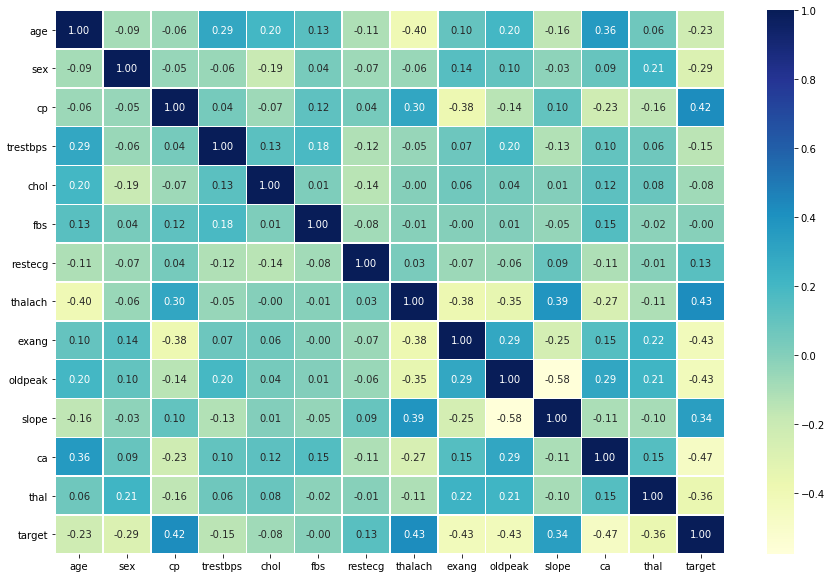

In [10]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.heatmap(df.corr(),
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

**Interpretation of correlation coefficient**

* The correlation coefficient ranges from -1 to +1.

* When it is close to +1, this signifies that there is a strong positive correlation. So, we can see that there is no variable which has strong positive correlation with `target` variable.

* When it is clsoe to -1, it means that there is a strong negative correlation. So, we can see that there is no variable which has strong negative correlation with `target` variable.

* When it is close to 0, it means that there is no correlation. So, there is no correlation between `target` and `fbs`.

* We can see that the `cp` and `thalach` variables are mildly positively correlated with target variable. So, I will analyze the interaction between these features and `target` variable.

Also, we are going to analize the age distribution and the relation between the target and the patient´s sex.

**Check the distribution of the age column with a histogram**

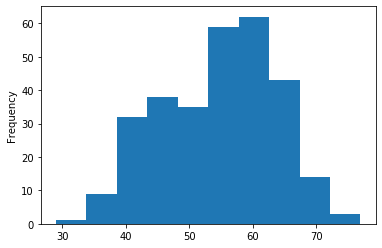

In [11]:
df['age'].plot.hist()

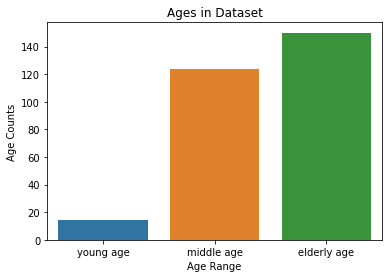

In [12]:
young_age = df[(df.age>=29)&(df.age<40)]
middle_age = df[(df.age>=40)&(df.age<55)]
elderly_age = df[(df.age>55)]

sns.barplot(x=['young age','middle age','elderly age'],y=[len(young_age),len(middle_age),len(elderly_age)])
plt.xlabel('Age Range')
plt.ylabel('Age Counts')
plt.title('Ages in Dataset')
plt.show()

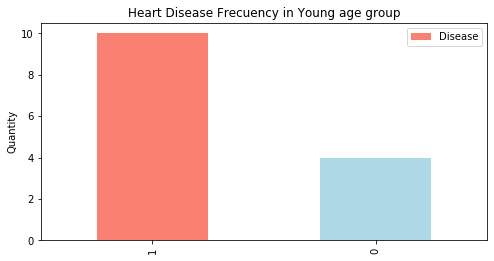

In [15]:
young_age['target'].value_counts().plot(kind='bar',
                                          figsize=(8,4),
                                          color=['salmon', 'lightblue'])

plt.title("Heart Disease Frecuency in Young age group")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

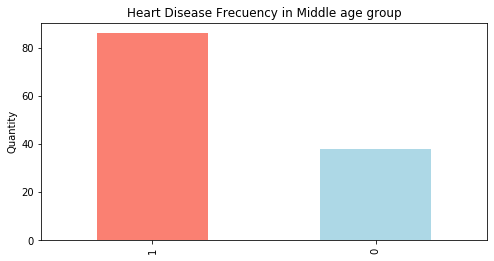

In [16]:
middle_age['target'].value_counts().plot(kind='bar',
                                          figsize=(8,4),
                                          color=['salmon', 'lightblue'])

plt.title("Heart Disease Frecuency in Middle age group")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

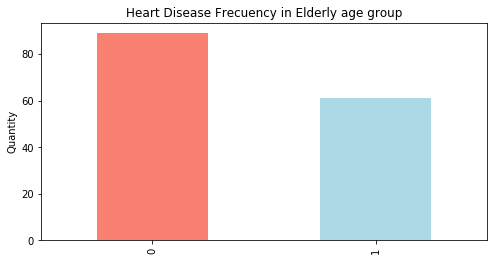

In [17]:
elderly_age['target'].value_counts().plot(kind='bar',
                                          figsize=(8,4),
                                          color=['salmon', 'lightblue'])

plt.title("Heart Disease Frecuency in Elderly age group")
plt.ylabel("Quantity")

**Distribution of positive heart disease per age**

The Graph suggests that the highest number of people suffering from heart diseases are in the age group of 55-65 years

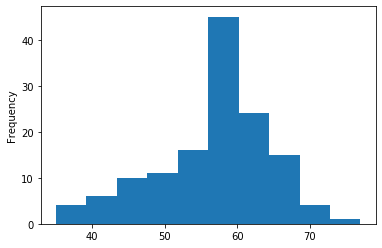

In [18]:
df[df['target'] == 0]['age'].plot.hist()

**Heart Disease Frecuency for Sex**

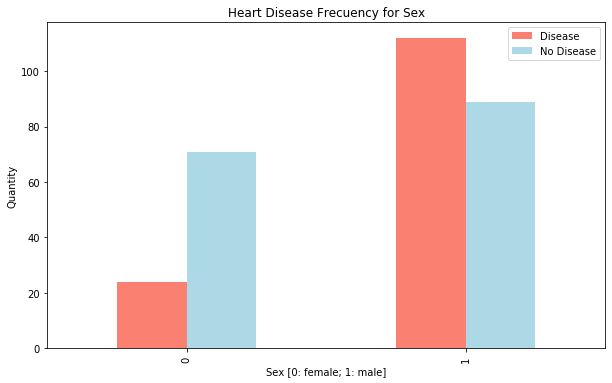

In [19]:
pd.crosstab(df['sex'], df['target']).plot(kind='bar',
                                          figsize=(10,6),
                                          color=['salmon', 'lightblue'])
plt.title("Heart Disease Frecuency for Sex")
plt.xlabel("Sex [0: female; 1: male]")
plt.ylabel("Quantity")
plt.legend(["Disease", "No Disease"]);

We can assume that Males are more likely to suffer from heart diseases in comparison to females.

**Heart Disease Frecuency per Chest Pain Type**

Remember: `cp` - chest pain type
* value 0: Typical angina: chest pain related decrease blood supply to the heart
* value 1: Atypical angina: chest pain not related to heart
* value 2: Non-anginal pain: typically esophageal spasms (non heart related)
* value 3: Asymptomatic: chest pain not showing signs of disease

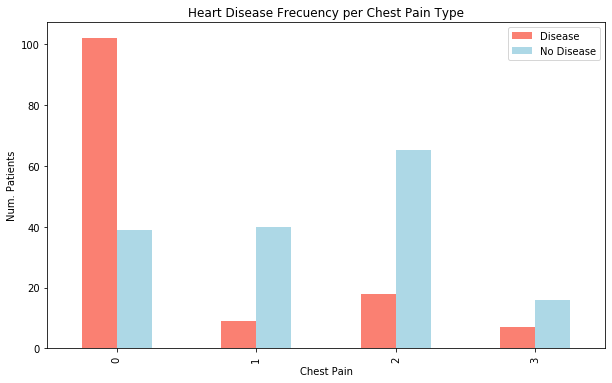

In [20]:
pd.crosstab(df['cp'], df['target']).plot(kind='bar',
                                          figsize=(10,6),
                                          color=['salmon', 'lightblue'])
plt.title("Heart Disease Frecuency per Chest Pain Type")
plt.xlabel("Chest Pain")
plt.ylabel("Num. Patients")
plt.legend(["Disease", "No Disease"]);

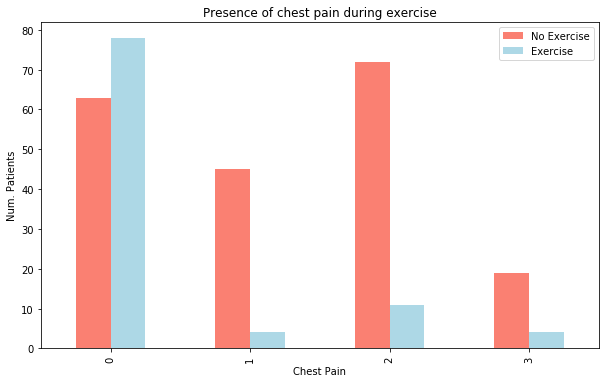

In [21]:
pd.crosstab(df['cp'], df['exang']).plot(kind='bar',
                                          figsize=(10,6),
                                          color=['salmon', 'lightblue'])
plt.title("Presence of chest pain during exercise")
plt.xlabel("Chest Pain")
plt.ylabel("Num. Patients")
plt.legend(["No Exercise", "Exercise"]);

**Heart Disease in function of Age and Max Heart Rate**

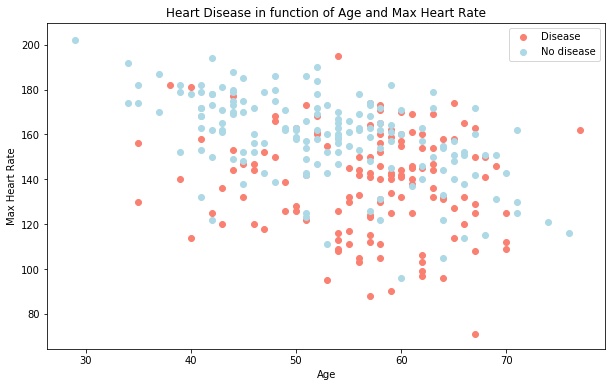

In [22]:
plt.figure(figsize=(10,6))

scat = df[df['target'] == 0]
# scatter the positive results
plt.scatter(scat['age'],
            scat['thalach'],
            c='salmon')

scat = df[df['target'] == 1]
# scatter the negative results
plt.scatter(scat['age'],
            scat['thalach'],
            c='lightblue')

plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease", "No disease"])

**Visualize the frequency distribution of thalach variable**

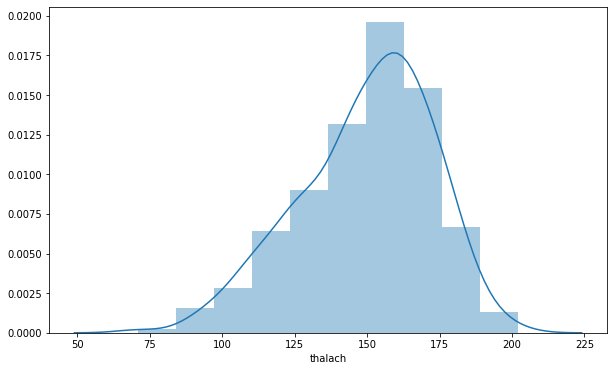

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(df['thalach'], bins=10)
plt.show()

# Modelling

In [24]:
# Split data into X and y
X = df.drop("target", axis=1)
y = df["target"]

In [25]:
# Set random seed to replicate results
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

We're going to try 3 different machine learning models:

* Logistic Regression
* K-Nearest Neighbours Classifier
* Random Forest Classifier

In [26]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    -----------------------------------
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores


In [27]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

C:\Users\Juan\Desktop\data-science-exercises\heart_disease_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Model comparison**

In [28]:
model_scores

{'Logistic Regression': 0.8666666666666667,
 'KNN': 0.7666666666666667,
 'Random Forest': 0.85}

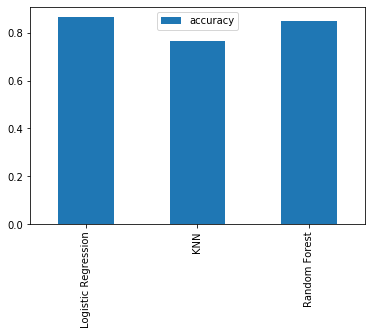

In [29]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

Now that we've got baseline models and we know a model's first predictions aren't always what we should based our next steps off, we are going to proceed to hyperparameter tuning.

* First, we tune the KNN by hand as a test
* Second, we tune the three models through the RandomSearchCV
* Third, with the model that has the best results from RandomSearchCV, we try a GridSearchCV

## Hyperparameter tuning (by hand)

In [30]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))

    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 78.33%


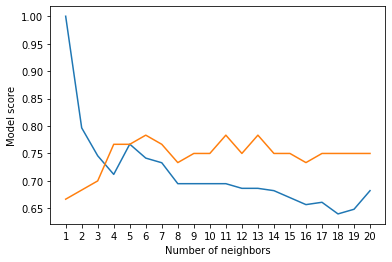

In [31]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

## Hyperparameter tuning with RandomizedSearchCV

In [32]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for KNeighborsClassifier
knn_grid = {'n_neighbors': range(1, 21),
            'weights': ['uniform', 'distance']}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [33]:
# Tune LogisticRegression

# Set random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C':...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

In [34]:
# Print the best hyperparameters
print(f"Best hyperparameters: {rs_log_reg.best_params_}")

# Get score from best params
model_scores['Logistic Regression'] = rs_log_reg.score(X_test, y_test)
print(f"Log. Reg. score: {model_scores['Logistic Regression']}")

Best hyperparameters: {'solver': 'liblinear', 'C': 0.615848211066026}
Log. Reg. score: 0.8666666666666667


In [35]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for KNeighborsClassifier
rs_knn = RandomizedSearchCV(KNeighborsClassifier(), 
                           param_distributions=knn_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'n_neighbors': range(1, 21),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=True)

In [36]:
# Print the best hyperparameters
print(f"Best hyperparameters: {rs_knn.best_params_}")

# Get score from best params
model_scores['KNN'] = rs_knn.score(X_test, y_test)
print(f"KNN score: {model_scores['KNN']}")

Best hyperparameters: {'weights': 'uniform', 'n_neighbors': 5}
KNN score: 0.7666666666666667


In [37]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [38]:
# Print the best hyperparameters
print(f"Best hyperparameters: {rs_rf.best_params_}")

# Get score from best params
model_scores['Random Forest'] = rs_rf.score(X_test, y_test)
print(f"Random Forest score: {model_scores['Random Forest']}")

Best hyperparameters: {'n_estimators': 310, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': None}
Random Forest score: 0.8833333333333333


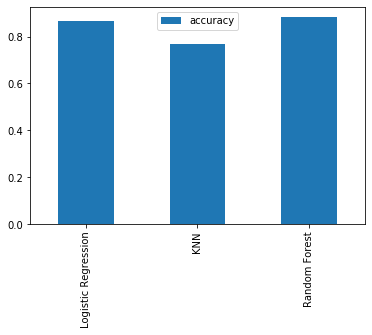

In [39]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

As the best result are gotten from the Random Fores Classifiers, the GridSearchCV will be made from that model.

## Hyperparameter Tuning with GridSearchCV

In [40]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 400, 100),
           "max_depth": [None, 3],
           "min_samples_split": np.arange(2, 13, 2),
           "min_samples_leaf": np.arange(1, 10, 2)}

# rf_grid = {"n_estimators": np.arange(10, 1000, 50),
#            "max_depth": [None, 3, 5, 10],
#            "min_samples_split": np.arange(2, 20, 2),
#            "min_samples_leaf": np.arange(1, 20, 2)}


# Setup grid hyperparameter search for LogisticRegression
gs_rf = GridSearchCV(RandomForestClassifier(),
                          param_grid=rf_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  9.3min finished


In [41]:
# Print the best hyperparameters
print(f"Best hyperparameters: {gs_rf.best_params_}")

# Get score from best params
gs_rf.score(X_test, y_test)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 210}


0.8666666666666667

## Evaluating the tuned machine learning classifier, beyond accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

... and it would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.

In [42]:
# Make predictions with tuned model
y_preds = gs_rf.predict(X_test)

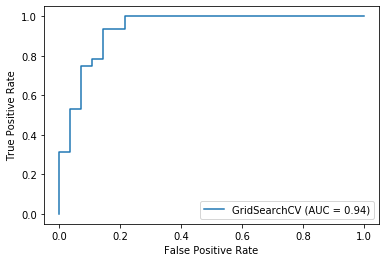

In [43]:
# Plot ROC curve and calculate and calculate AUC metric
# Way of understanding how the model is performing by comparing the true positive rate to the false positive rate

# ROC: Receiver Operating Characterisitc is a plot of true positive rate versus false positive rate.
# AUC: The area underneath the ROC curve. A perfect model achieves a score of 1.0.
plot_roc_curve(gs_rf, X_test, y_test)

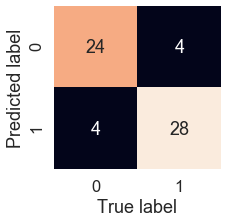

In [44]:
# We need a way to show where the model made the right predictions and where it made the wrong predictions 
# (or in other words, got confused).

# Confusion matrix
# Compares the predicted values with the true values in a tabular way, if 100% correct, 
# all values in the matrix will be top left to bottom right (diagonal line).

sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_conf_mat(y_test, y_preds)

In [45]:
# Classification Report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.88      0.88      0.88        32

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



### Calculate evaluation metrics using cross-validation

The next step to make the model more solid is calculate them using cross-validation.
I'll take the best model along with the best hyperparameters and use cross_val_score() along with various scoring parameter values.

I´m going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using cross_val_score().

In [46]:
# Check best hyperparameters
gs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 210}

In [47]:
# Create a new classifier with best parameters
rf = RandomForestClassifier(n_estimators=210,
                            max_depth=None,
                            min_samples_leaf=1,
                            min_samples_split=10)

In [48]:
# Cross-validated accuracy
cv_acc = cross_val_score(rf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc =  np.mean(cv_acc)
cv_acc

0.8344632768361582

In [49]:
# Cross-validated precision
# Precision: Proportion of true positives over total number of samples. Higher precision leads to less false positives.

cv_precision = cross_val_score(rf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.84362480127186

In [51]:
# Cross-validated recall
# Recall: Proportion of true positives over total number of true positives and false negatives. Higher recall leads to less false negatives.

cv_recall = cross_val_score(rf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.875

In [52]:
# Cross-validated f1-score
# F1-score: Combines precision and recall into one metric. 1 is best, 0 is worst.

cv_f1 = cross_val_score(rf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.8506890331890332

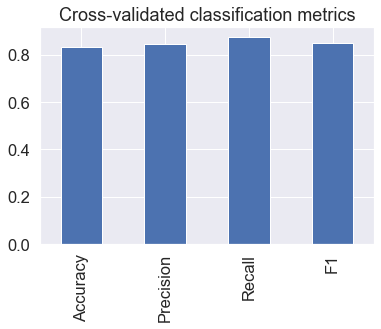

In [53]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                           index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

## Feature importance

Which features contributed most to the outcomes of the model and how did they contribute?

For our problem, trying to predict heart disease using a patient's medical characterisitcs, which charateristics contribute most to a model predicting whether someone has heart disease or not?

Unlike some of the other functions we've seen, because how each model finds patterns in data is slightly different, how a model judges how important those patterns are is different as well. This means for each model, there's a slightly different way of finding which features were most important.

In [54]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=210,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
# Check coef_
rf.feature_importances_

array([0.06381791, 0.05612624, 0.14560384, 0.0516779 , 0.05411465,
       0.00793402, 0.01213173, 0.10448956, 0.03273842, 0.10603686,
       0.0450171 , 0.1831099 , 0.13720188])

In [56]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
ca,0.183110
cp,0.145604
thal,0.137202
oldpeak,0.106037
thalach,0.104490
age,0.063818
sex,0.056126
chol,0.054115
trestbps,0.051678
slope,0.045017


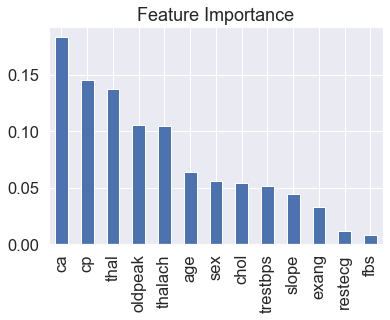

In [57]:
# Visualize feature importance
feature_importances.plot.bar(title="Feature Importance", legend=False);

What can we do with this information?

We might want to talk to a subject matter expert about this features. They may be interested in seeing where machine learning model is finding the most patterns (highest correlation) as well as where it's not (lowest correlation).

Doing this has a few benefits:

* **Finding out more** - If some of the correlations and feature importances are confusing, a subject matter expert may be able to shed some light on the situation and help us figure out more. We can also return to the EDA an try new visualizations based in the Feature Importance.
* **Redirecting efforts** - If some features offer far more value than others, this may change how we collect data for different problems.
* **Less but better** - Similar to above, if some features are offering far more value than others, we could reduce the number of features the model tries to find patterns in as well as improve the ones which offer the most. This could potentially lead to saving on computation, by having a model find patterns across less features, whilst still achieving the same performance levels.

## 6. Experimentation

* Could we collect more data?
* Could we try a better model? Might want to look into CatBoost or XGBoost.
* Could we improve the current models? (beyond what we've done so far)